In [9]:
library(readxl)
library(ggplot2)
library(stringr)
library(dplyr)

glrvs <- guides(fill=guide_legend(reverse = TRUE), 
                color=guide_legend(reverse = TRUE)) 
setwd("~/Project_timeSeriesAnalysis/data")

In [10]:
pssData = read_excel("DLUL_PRB_TOT_PRB_1110537_20160919105501.xls",skip=2)
dim(pssData)
colnames(pssData)[1] <- "complexinfo"

#tip.  strdf <- pssData[,1]  # a dataframe not a vector
#pssData$eNB <- str_extract(pssData[,1], "\\d-\\d{5}")  #cannot manage dataframes as inputs..

pssData$eNB <- str_extract(pssData$complexinfo, "\\d-\\d{5}")
selDeleteLine <- str_detect(pssData$complexinfo, "[소총] 계")
pssData <- pssData[!selDeleteLine,]
dim(pssData)

colnames(pssData) <- str_replace(colnames(pssData),"\\(.*\\)", "")

[1] 3285   44

[1] 2724   45

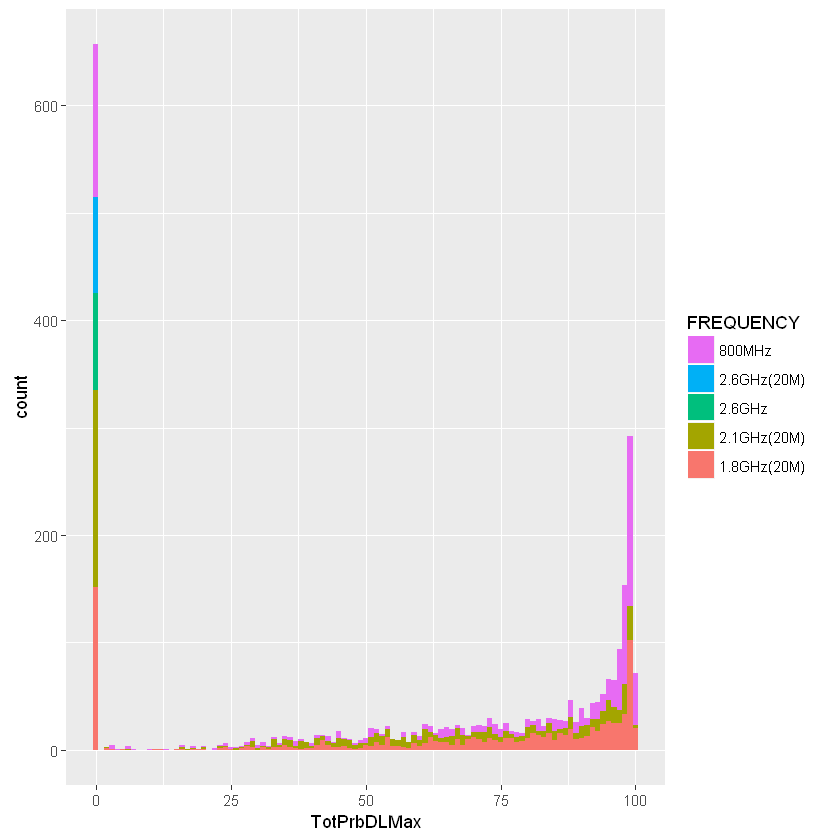

In [4]:
ggplot(pssData, aes(x=TotPrbDLMax, fill= FREQUENCY)) + geom_histogram(binwidth = 1) + glrvs

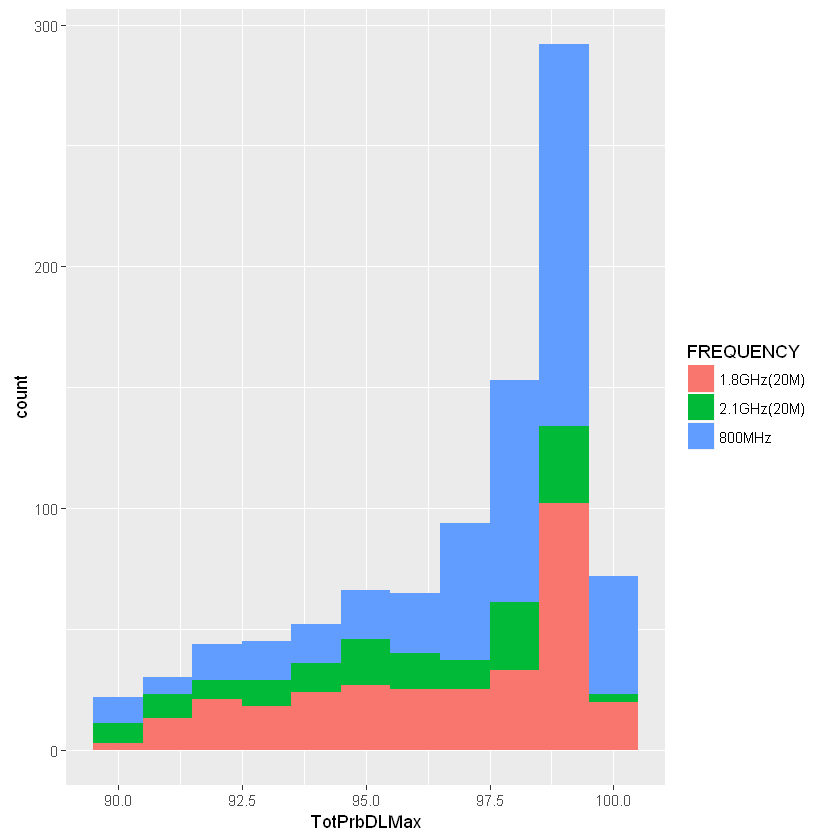

In [5]:
heavyCell  <- pssData[pssData$TotPrbDLMax >90,]
ggplot(heavyCell, aes(x=TotPrbDLMax, fill= FREQUENCY)) + geom_histogram(binwidth = 1)

In [6]:
dim(heavyCell)
heavyCellList <- pssData %>% select(eNB, CNUM)

[1] 935  45

In [7]:
pss5min <- read.csv("pss5min1.csv")
selDeleteLine = str_detect(pss5min[,2], "[소총] 계")
pss5min <- pss5min[!selDeleteLine, ]
pss5min$dist <- cut(pss5min$TotPrbDLMax,breaks = seq(0,100, by=10),labels = seq(10,100, by=10), include.lowest = TRUE)

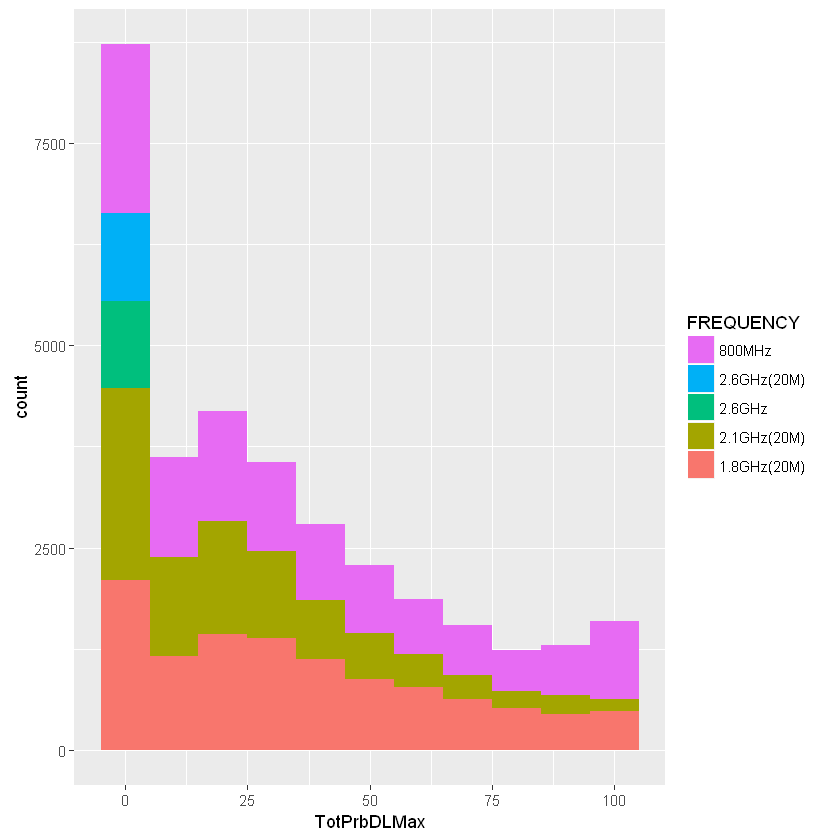

In [8]:
ggplot(pss5min, aes(x=TotPrbDLMax, fill= FREQUENCY)) + geom_histogram(binwidth = 10) + glrvs

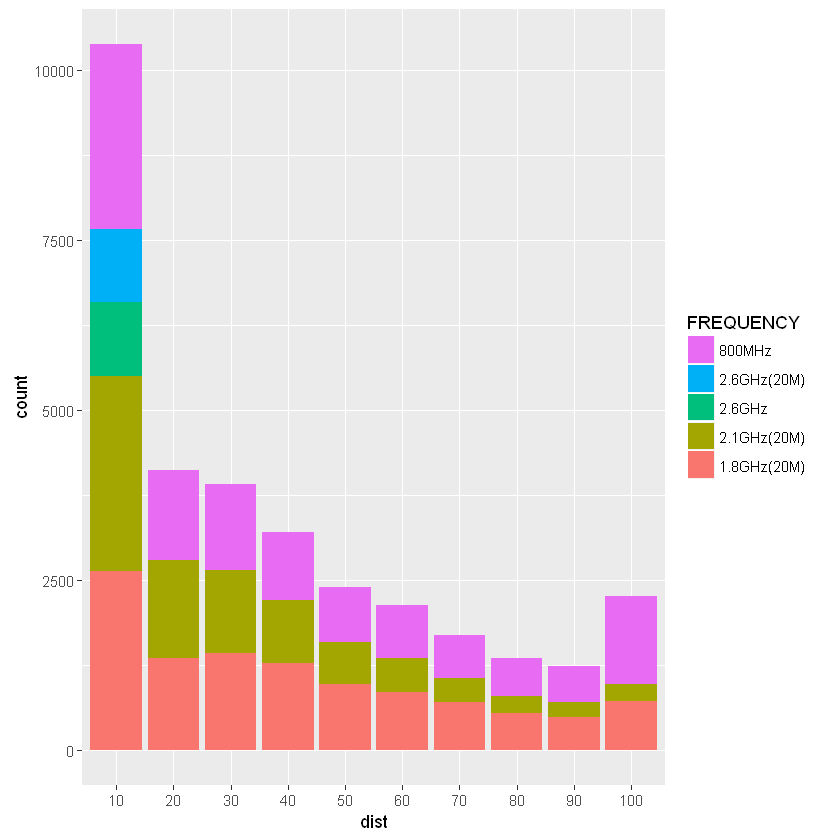

In [9]:
ggplot(pss5min, aes(x=dist, fill= FREQUENCY)) + geom_bar() + glrvs

10    20    30    40    50    60    70    80    90   100 
10381  4115  3906  3205  2402  2132  1694  1358  1230  2265


            1.8GHz(20M) 2.1GHz(20M)      2.6GHz 2.6GHz(20M)      800MHz 
          0       10944        8640        1080        1080       10944 

.
            1.8GHz(20M) 2.1GHz(20M)      2.6GHz 2.6GHz(20M)      800MHz 
          0        1824        2196        1080        1080        1704 

[1] 2.1GHz(20M) 1.8GHz(20M) 800MHz      2.6GHz      2.6GHz(20M)
Levels:  1.8GHz(20M) 2.1GHz(20M) 2.6GHz 2.6GHz(20M) 800MHz

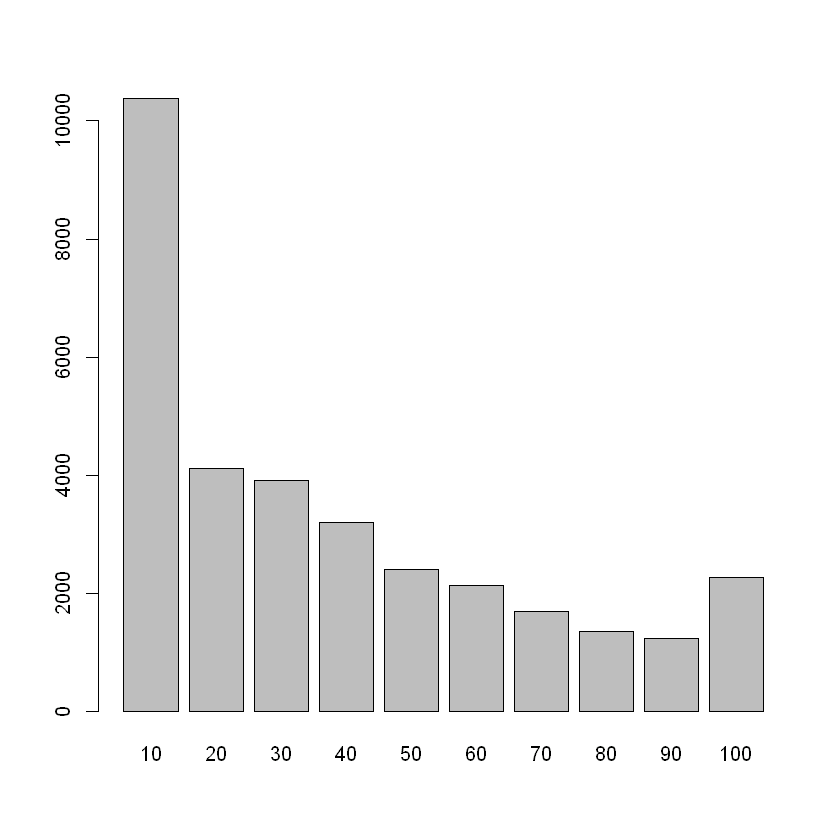

In [10]:
summary(pss5min$dist)
plot(pss5min$dist)
table(pss5min$FREQUENCY)
pss5min  %>% filter(TotPrbDLMax < 1.) %>% select(FREQUENCY) %>% table
# 2.6GHz not activated..
unique(pss5min$FREQUENCY)

# delete inactive cell rows... 2.6GHz...
selDelLine <- str_detect(pss5min$FREQUENCY, "2.6GHz")
pss5min <- pss5min[!selDelLine, ]

# to find cell id on which max prb is above 90
heavyList5min <- pss5min %>%  filter(TotPrbDLMax > 90) %>% select(eNB, CNUM, time,TotPrbDLMax)

# time series graph...




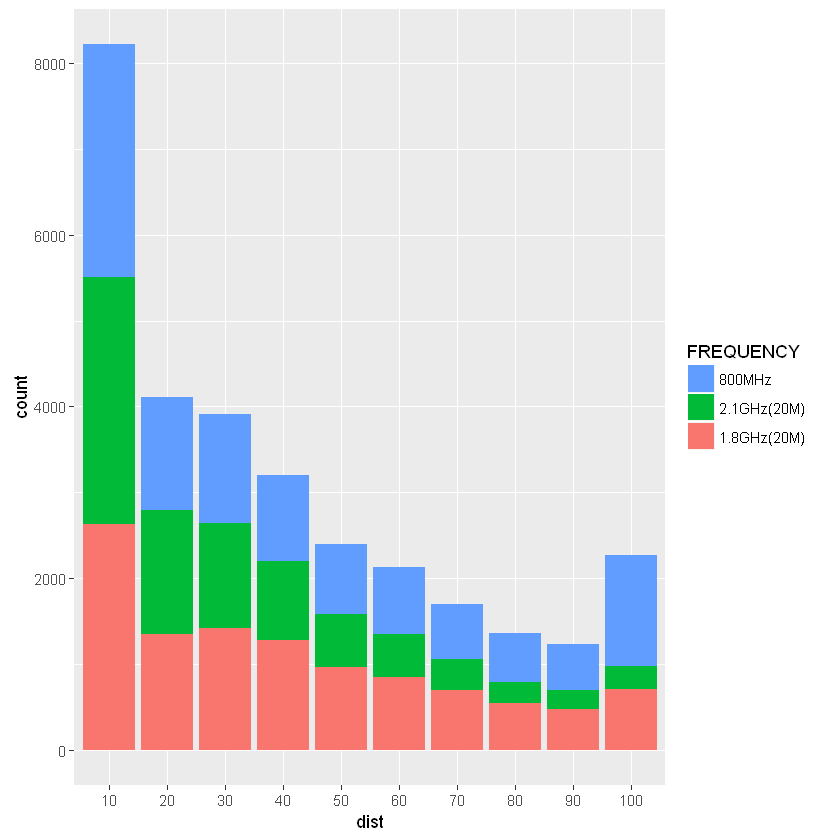

In [16]:
ggplot(pss5min, aes(x=dist, fill= FREQUENCY)) + geom_bar() + glrvs

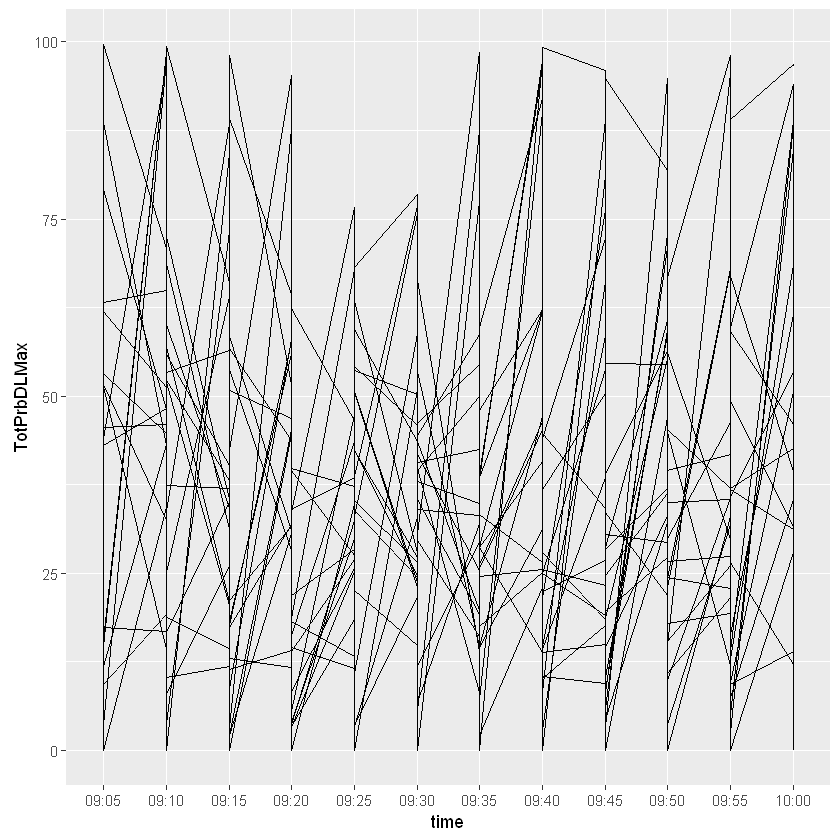

In [11]:
ggplot(pss5min %>% filter(eNB %in% c('1-26507','1-26508')), aes(x=time, y=TotPrbDLMax, group=CNUM)) + geom_line()


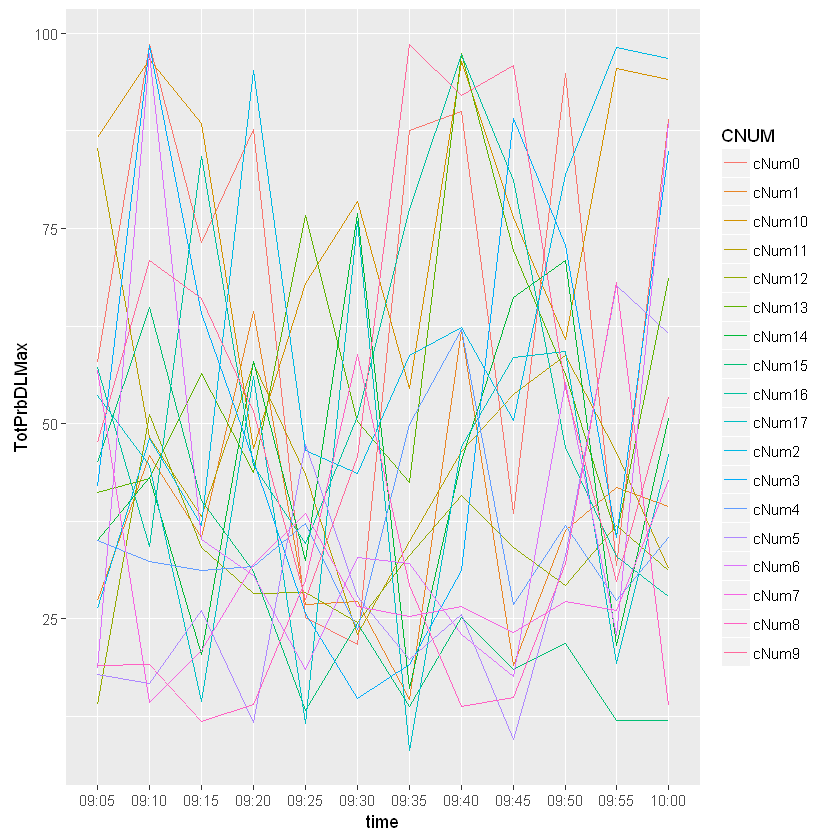

In [12]:
ggplot(pss5min %>% filter(eNB =='1-26507'), aes(x=time, y=TotPrbDLMax, color=CNUM, group=CNUM)) + geom_line()

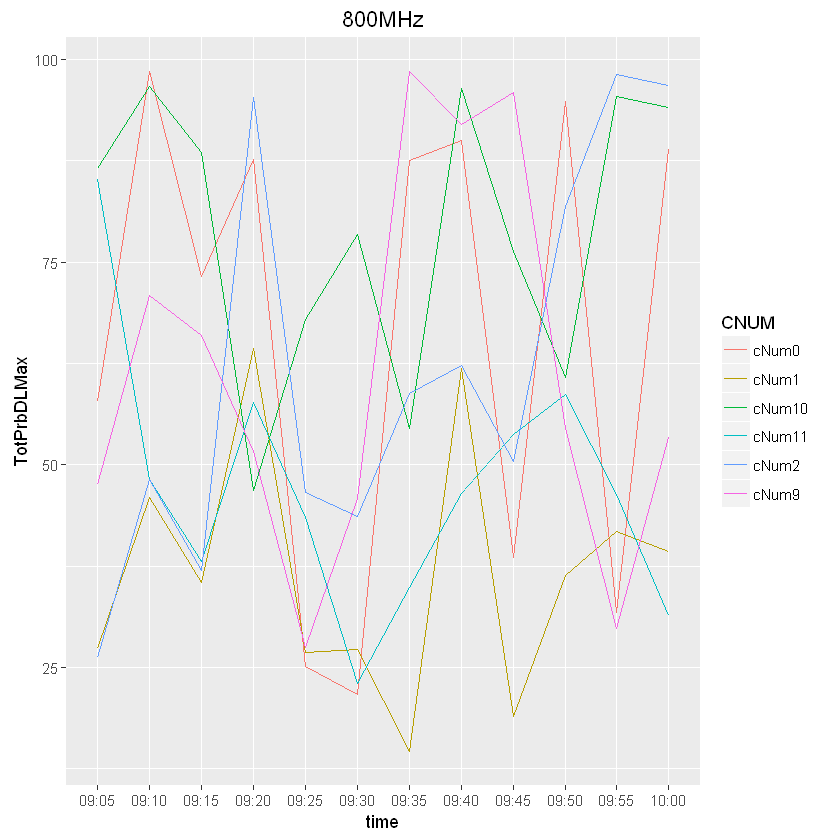

In [13]:
ggplot(pss5min %>% filter(eNB =='1-26507', FREQUENCY=="800MHz"), aes(x=time, y=TotPrbDLMax, color=CNUM, group=CNUM)) + geom_line() + ggtitle("800MHz")


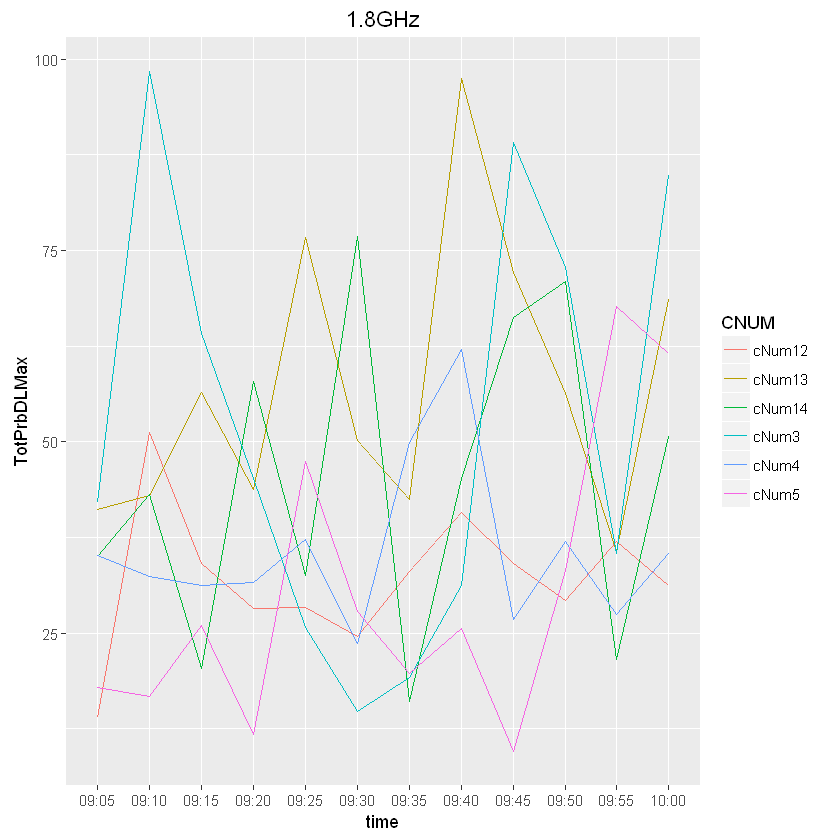

In [14]:
ggplot(pss5min %>% filter(eNB =='1-26507', FREQUENCY=="1.8GHz(20M)"), aes(x=time, y=TotPrbDLMax, color=CNUM, group=CNUM)) + geom_line()+ ggtitle("1.8GHz")


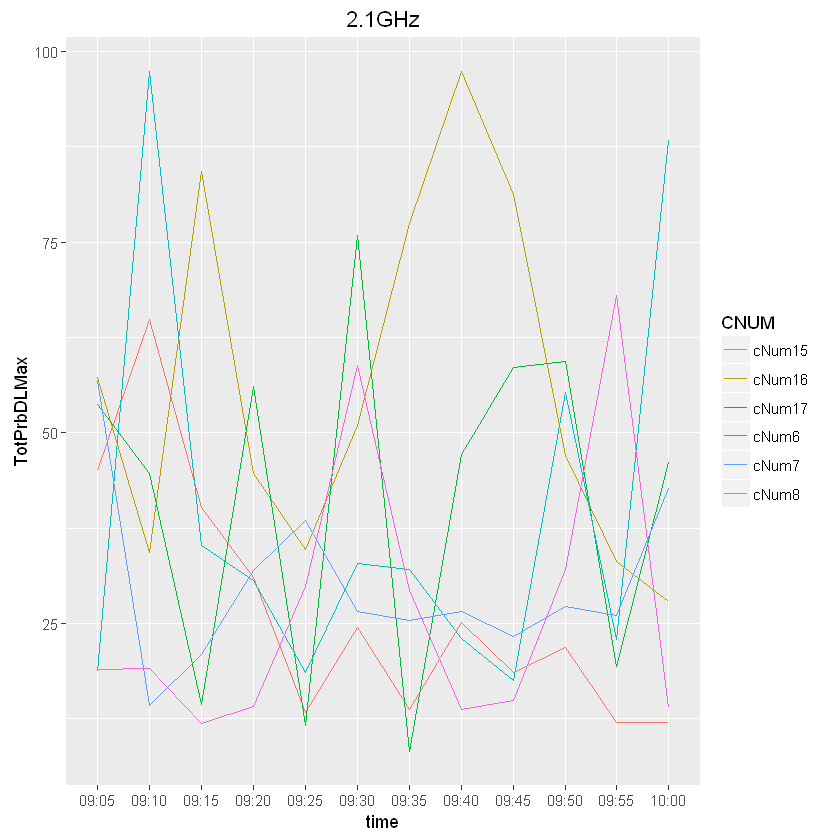

In [15]:
ggplot(pss5min %>% filter(eNB =='1-26507', FREQUENCY=="2.1GHz(20M)"), aes(x=time, y=TotPrbDLMax, color=CNUM, group=CNUM)) + geom_line()+ ggtitle("2.1GHz")


In [11]:
mungfile <- function(filename,date){ # date:string, "2016-09-20"
        var_df <- read.csv(filename)
        selDeleteLine = str_detect(var_df[,2], "[소총] 계")
        var_df <- var_df[!selDeleteLine, ]
        var_df$dist <- cut(var_df$TotPrbDLMax,breaks = seq(0,100, by=10),
                           labels = seq(10,100, by=10), include.lowest = TRUE)
        var_df$datetime <- str_c(date, var_df$time, sep=" ")
        var_df$datetime <- as.POSIXct(strptime(var_df$datetime,"%Y-%m-%d %H:%M", tz="GMT"))
        var_df$date <- date
        cellnum <- str_extract(var_df$CNUM, "\\d\\d?")
        var_df$cellid <- str_c(var_df$eNB, cellnum, sep = "-")
        return(var_df)
}


In [12]:
p5min0919 <- mungfile("pss5min0919.csv","2016-09-19")
p5min0920 <- mungfile("pss5min0920.csv","2016-09-20")

p5min <-rbind(p5min0919, p5min0920)

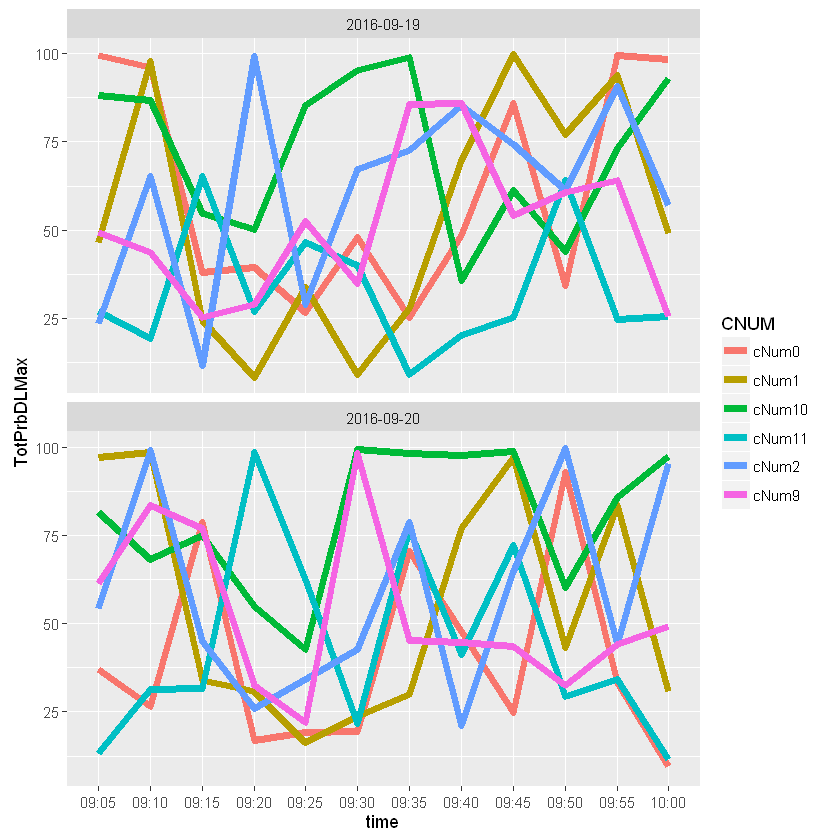

In [13]:
ggplot(p5min %>% filter(eNB =='1-26511', FREQUENCY=="800MHz"), 
       aes(x=time, y=TotPrbDLMax, color=CNUM, group=CNUM)) + geom_line(size=2) + facet_wrap(~date, ncol = 1)


In [14]:
library(dtw)

In [15]:
mkMTX <- function(df, Freq){
        cellList <- df %>% filter(FREQUENCY==Freq) %>% select(cellid)
        cellList <- cellList[ ,1] # becomes a vector.
      
        mtx <- matrix(data=NA,nrow=length(cellList),ncol=12)
        for(i in 1:length(cellList)){
                selCellPrbMax <- 
                        df %>% filter(cellid==cellList[i], FREQUENCY==Freq) %>% 
                        select(date, time, TotPrbDLMax)
                mtx[i,] <- selCellPrbMax$TotPrbDLMax
                
        }
        return(mtx)
}


In [16]:

mtx0919 <- mkMTX(p5min0919, "800MHz")
mtx0920 <- mkMTX(p5min0920, "800MHz")
diff_mtx <- mtx0919 - mtx0920
m19mean <- apply(mtx0919,1,mean)
m19max <- apply(mtx0919,1,max)

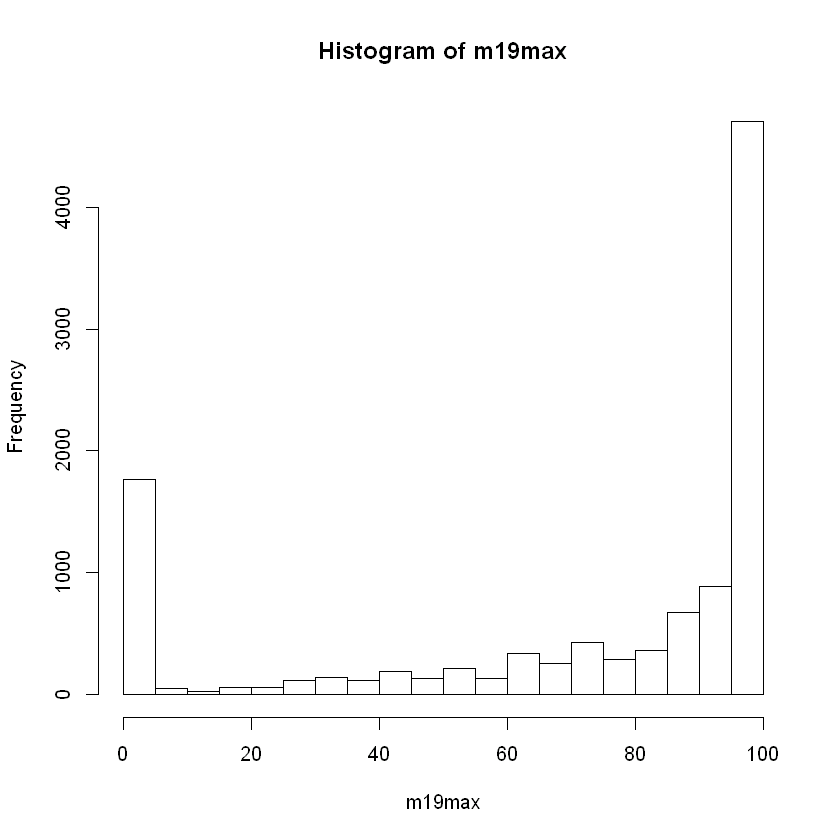

In [17]:
hist(m19max)

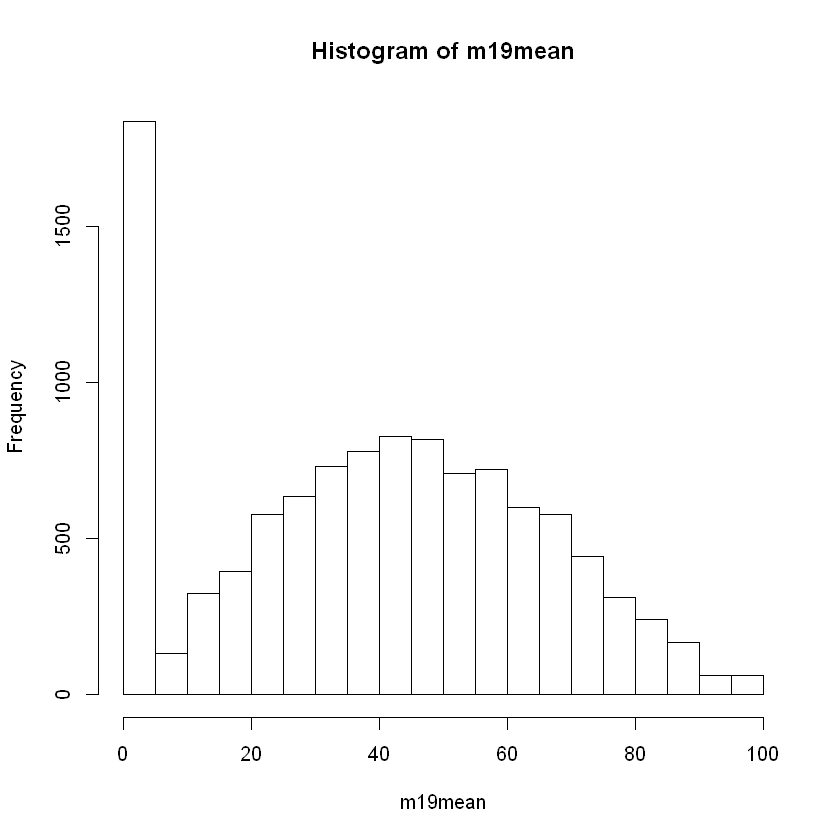

In [18]:
hist(m19mean)

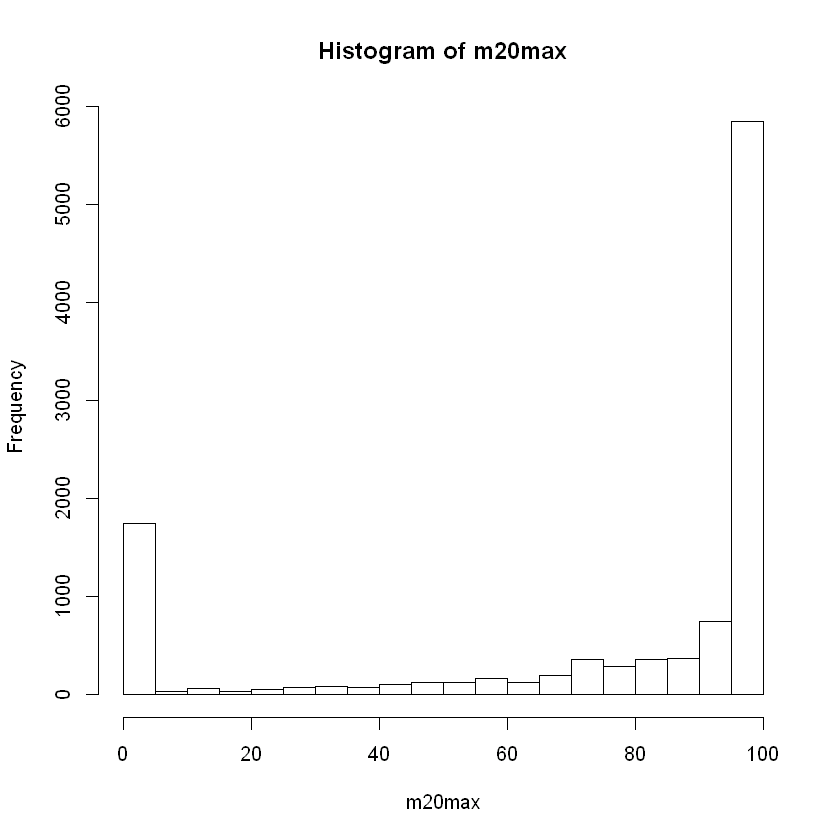

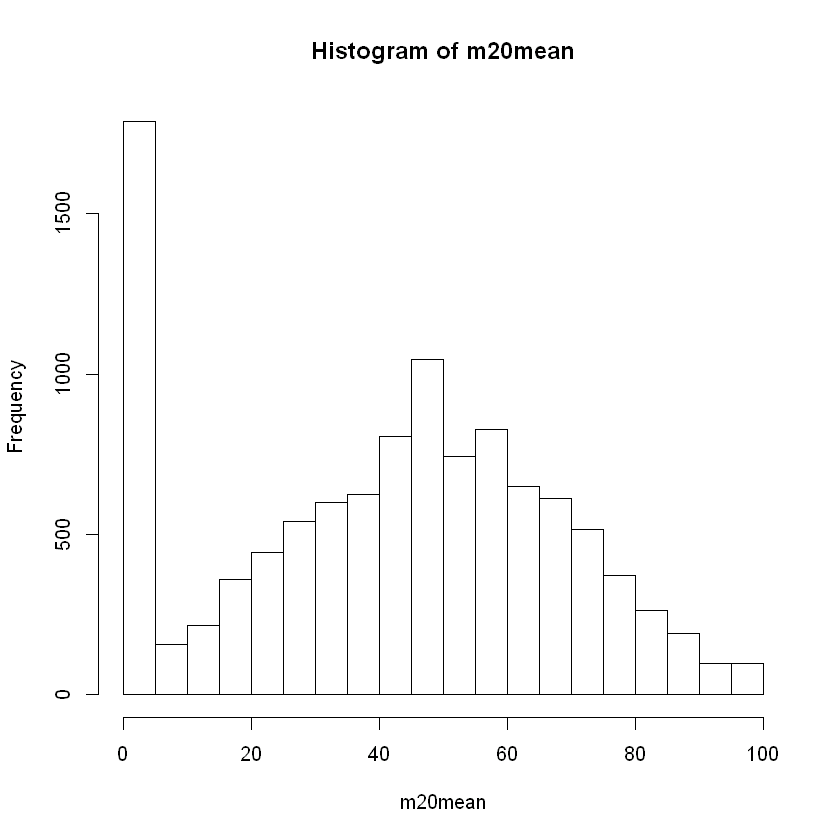

In [19]:
m20mean <- apply(mtx0920,1,mean)
m20max <- apply(mtx0920,1,max)

hist(m20max)
hist(m20mean)

diff_mean <- apply(abs(diff_mtx),1,mean)
diff_var <- apply(abs(diff_mtx),1,var)